# Analysis

In this notebook we perform exploratory data analysis.

## 1. Imports and setup

In [1]:
# Used to suppress warnings
import warnings

# Used for data manipulation
import pandas

# Used for plotting
import seaborn
from matplotlib import pyplot

In [2]:
warnings.filterwarnings("ignore")
seaborn.set_theme(style="whitegrid")

DATA_PATH = "../data/processed/apartments-for-sale.csv"

## 2. Initial data overview

In [3]:
data = pandas.read_csv(DATA_PATH, index_col=0)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2423 entries, 0 to 2422
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      2423 non-null   object 
 1   type       2423 non-null   object 
 2   m²         2423 non-null   float64
 3   posted_by  2423 non-null   object 
 4   city       2423 non-null   object 
 5   price_eur  2423 non-null   float64
dtypes: float64(2), object(4)
memory usage: 132.5+ KB


,state,type,m²,posted_by,city,price_eur
0,used,1 bedroom,39.0,agency,Sarajevo - Novi Grad,91290.0
1,used,4 bedroom,94.0,agency,Sarajevo - Novi Grad,283050.0
2,used,3 bedroom,58.0,agency,Sarajevo - Novo Sarajevo,152490.0
3,used,2 bedroom,52.0,agency,Sarajevo - Stari Grad,122400.0
4,used,2 bedroom,56.0,agency,Sarajevo - Novi Grad,124950.0


## 3. EDA

We define "natural" order for categories in the dataset, presumably going from less to more expensive, to be used in plots.

In [4]:
natural_order = {
    "posted_by": ["individual", "agency"],
    "state"    : ["not listed", "used", "new"],
    "type"     : [
        "studio",
        "1 bedroom",
        "1.5 bedroom",
        "2 bedroom",
        "3 bedroom",
        "4 bedroom",
        "5+ bedroom"
    ]
}

### 3.1. Counts

Here we take a look at the number of listings per given category.

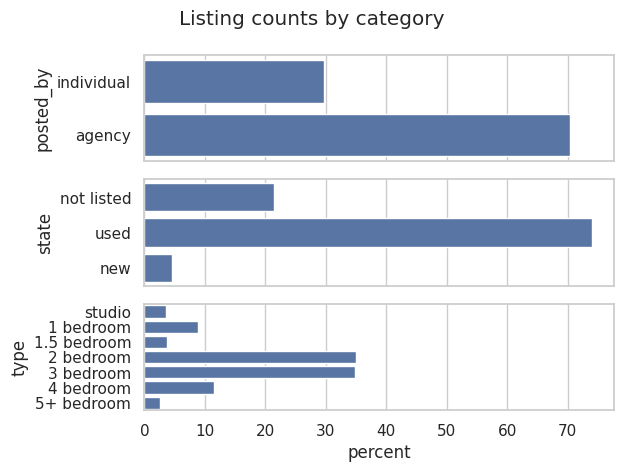

In [5]:
figure, subplots = pyplot.subplots(nrows=3, sharex=True)

for i, column in enumerate(["posted_by", "state", "type"]):
    seaborn.countplot(
        data, y=column,
        stat="percent", order=natural_order[column],
        ax=subplots[i]
    )

figure.suptitle("Listing counts by category")
figure.tight_layout()

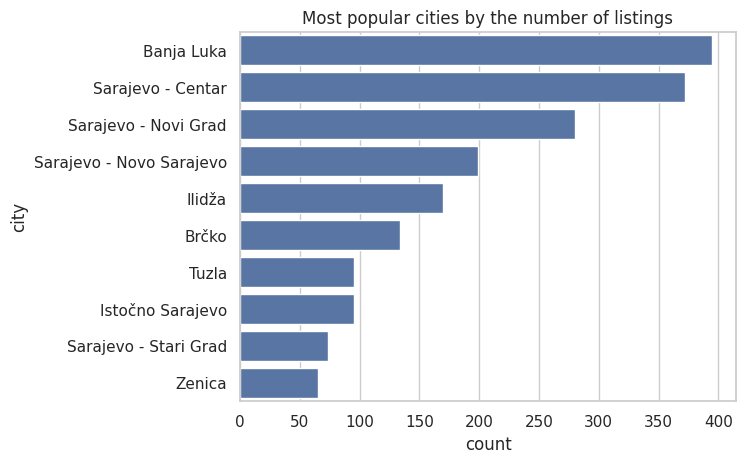

In [6]:
# Displaying only most popular cities, to avoid large, cluttered plot
display_count  = 10
popular_cities = data["city"].value_counts().head(display_count).index
cities_subset  = data.loc[data["city"].isin(popular_cities)]

plot = seaborn.countplot(
    cities_subset, y="city",
    order=popular_cities
)
plot.set_title("Most popular cities by the number of listings");

### 3.2. Distributions

Here we look at distributions of apartment sizes and prices.

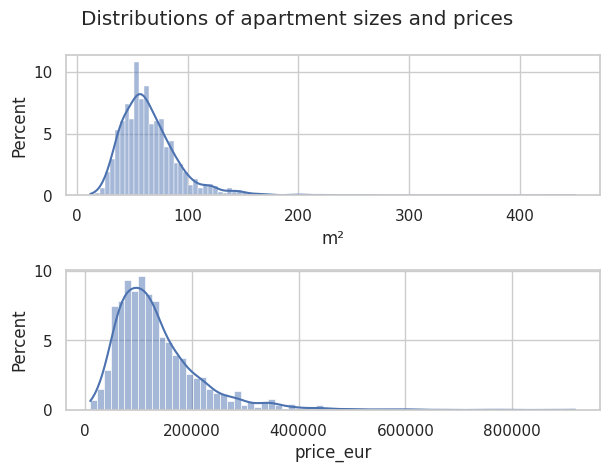

In [7]:
figure, subplots = pyplot.subplots(nrows=2)

for i, column in enumerate(["m²", "price_eur"]):
    seaborn.histplot(
        data, x=column,
        stat="percent", kde=True,
        ax=subplots[i]
    )

figure.suptitle("Distributions of apartment sizes and prices")
figure.tight_layout()

The majority of apartments are bellow 100 m² and cost under 200,000 euro, but both distributions are right-skewed.

## 4. Correlations

Next we check out how various columns are correlated with each other.

### 4.1. The Matrix

We plot a matrix of [Spearman coefficients](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) for pairs of columns, which shows how (monotonically) correlated the two columns are.

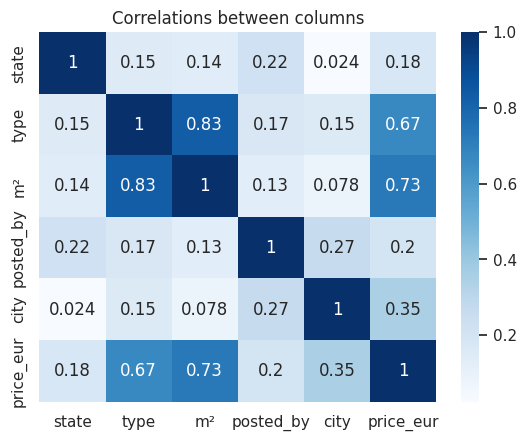

In [8]:
encoded_data = data.copy()

# Encode columns having "natural" order
for column, order in natural_order.items():
    encoded_data[column] = data[column].map(lambda value: order.index(value))

# Encode cities by popularity
cities_order = data["city"].value_counts().sort_values().index.to_list()
encoded_data["city"] = data["city"].map(lambda city: cities_order.index(city))


# Plot as a heatmap
correlations = seaborn.heatmap(
    encoded_data.corr(method="spearman"),
    annot=True, cmap="Blues"
)
correlations.set_title("Correlations between columns");

We can see some strong correlations:
- `m²` increases with  `type` (0.83) - more bedrooms tends to mean larger apartment
- `price_eur` increases with  `m²` (0.73) - larger apartments are more expensive
- `price_eur` increases with  `type` (0.67) - more bedrooms tends to mean more expensive apartment

We also see some weaker correlations:
- `price_eur` increases with  `city` (0.35) - more popular city correlates with more expensive apartments
- `posted_by` increases with  `city` (0.26) - more popular city correlates with more agency listings

### 4.2. Price vs. features

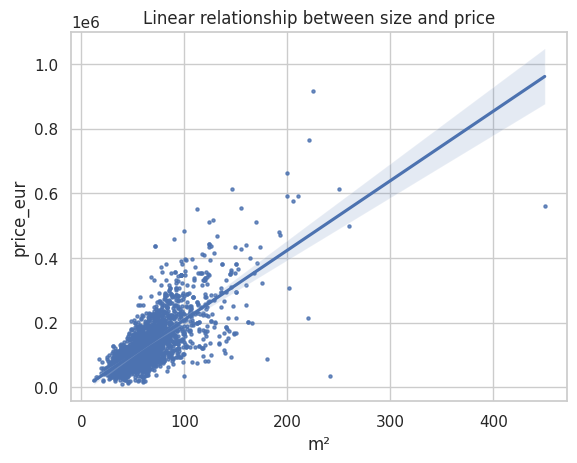

In [9]:
plot = seaborn.regplot(
    data, x="m²", y="price_eur",
    scatter_kws={"s": 5}
)
plot.set_title("Linear relationship between size and price");

Price is reasonably proportional to the size, as expected.

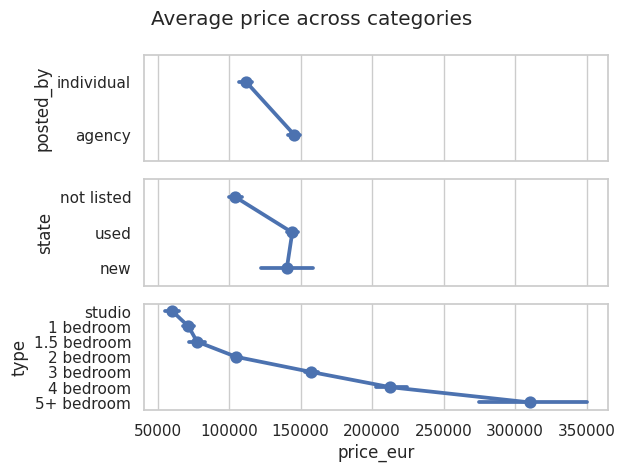

In [10]:
figure, subplots = pyplot.subplots(nrows=3, sharex=True)

for i, column in enumerate(["posted_by", "state", "type"]):
    seaborn.pointplot(
        data, x="price_eur", y=column,
        order=natural_order[column],
        ax=subplots[i]
    )

figure.suptitle("Average price across categories")
figure.tight_layout()

- Agencies tend to list more expensive apartments, compared to individuals.  
- There is more variation in the price of new apartments.  
- Price rises with number of bedrooms, as expected and shown previously.

In [11]:
# Cities sorted by mean apartment price
mean_price_order = cities_subset.groupby("city")["price_eur"].mean() \
    .sort_values(ascending=False).index

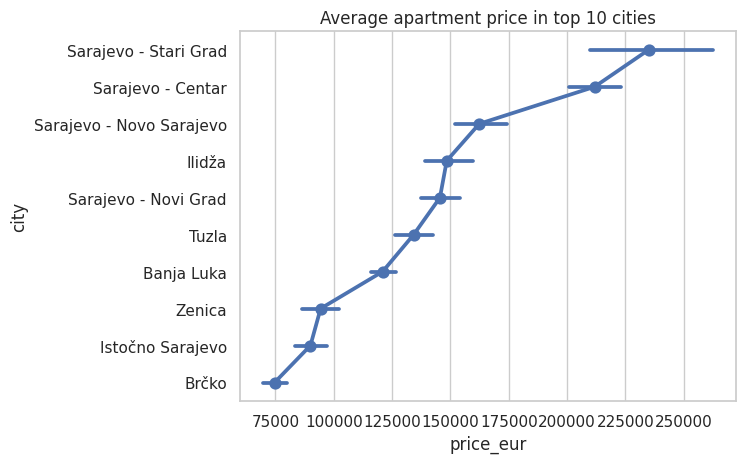

In [12]:
plot = seaborn.pointplot(
    cities_subset, x="price_eur", y="city",
    order=mean_price_order
)
plot.set_title("Average apartment price in top 10 cities");

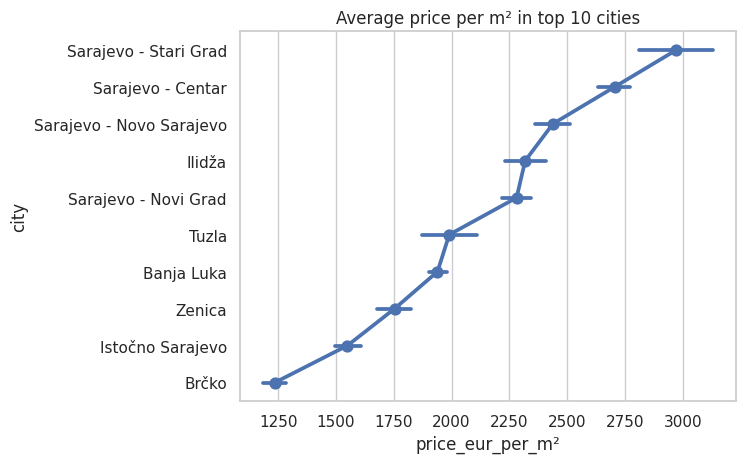

In [13]:
cities_subset["price_eur_per_m²"] = cities_subset["price_eur"] / cities_subset["m²"]

plot = seaborn.pointplot(
    cities_subset, x="price_eur_per_m²", y="city",
    order=mean_price_order
)
plot.set_title("Average price per m² in top 10 cities");

The order doesn't seem to change when adjusting for size, but Stari Grad and Centar seem to have relatively larger apartments listed.

---

In the next notebook, we build models to predict the apartment price given its features like size, number of bedrooms, city, etc.